In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [2]:
# Fungsi untuk mempersiapkan data
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Unduh dan muat data dari Yahoo Finance
symbol = '^JKLQ45'  # Simbol untuk indeks LQ-45
start_date = '1997-02-25'
end_date = '2024-01-31'
data = yf.download(symbol, start=start_date, end=end_date)['Close'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


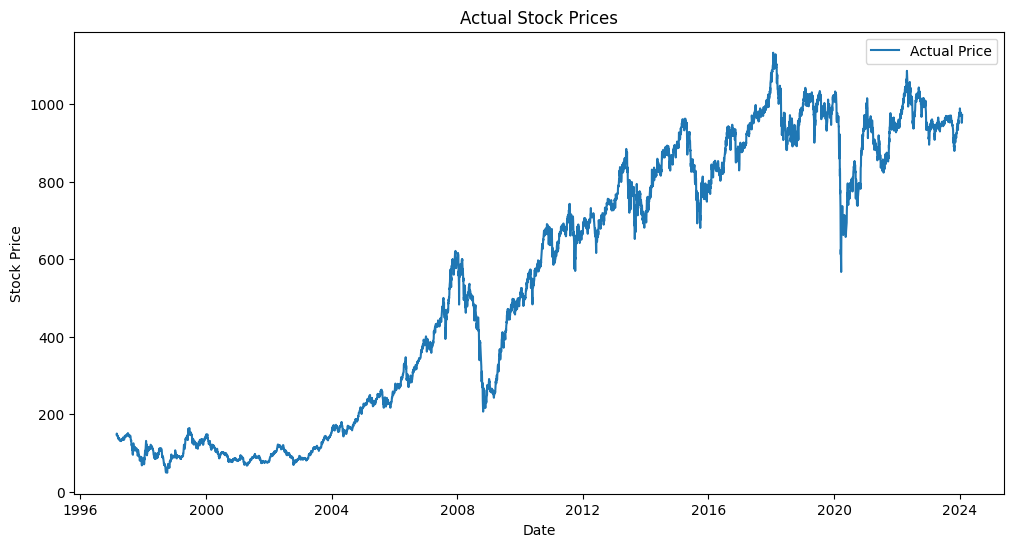

In [3]:
# Ambil tanggal untuk plot
dates = yf.download(symbol, start=start_date, end=end_date).index

# Plotting DataFrame secara full sebelum pelatihan
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(scaled_data), label='Actual Price')
plt.title('Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [4]:
# Tentukan parameter
time_steps = 60  # Panjang sekuens input untuk model
train_size = int(len(scaled_data) * 0.7)  # Ukuran set pelatihan
validation_size = int(train_size * 0.1)  # Ukuran set validasi
test_size = len(scaled_data) - train_size

In [5]:
# Persiapkan data train, validation, dan test
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+validation_size]
test_data = scaled_data[train_size+validation_size:]

X_train, y_train = prepare_data(train_data, time_steps)
X_val, y_val = prepare_data(val_data, time_steps)
X_test, y_test = prepare_data(test_data, time_steps)

In [6]:
def fruit_fly_algorithm(num_flies, num_iterations, X_train, y_train, X_val, y_val, scaler):
    def create_model(params):
        units, lr, dropout, activation, batch_size, num_layers, epochs = params
        model = Sequential([Input(shape=(X_train.shape[1], X_train.shape[2]))])

        # Add GRU layers dynamically based on num_layers
        for _ in range(num_layers):
            model.add(GRU(units=int(units), activation=activation, dropout=dropout, return_sequences=True if _ < num_layers - 1 else False))

        model.add(Dense(units=1))  # Output layer
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model, batch_size, epochs

    best_rmse = float('inf')
    best_params = None
    results = []

    for iteration in range(num_iterations):
        for fly in range(num_flies):
            # Updated random parameter ranges
            units = np.random.randint(16, 256)  # GRU units
            lr = 10 ** np.random.uniform(-6, -1)  # Learning rate
            dropout = 10 ** np.random.uniform(-5, -3) # Dropout rate
            activation = np.random.choice(['tanh', 'relu', 'selu', 'sigmoid'])  # Activation function
            batch_size = np.random.choice([8, 16, 32, 64, 128, 256])  # Batch size
            num_layers = np.random.randint(1, 6)  # Number of GRU layers (1 to 5)
            epochs = np.random.randint(10, 100)  # Epochs (10 to 100)

            params = [units, lr, dropout, activation, batch_size, num_layers, epochs]
            model, batch_size, epochs = create_model(params)

            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])

            # Calculate RMSE
            predictions = model.predict(X_val)

            # Handle NaN values
            if np.isnan(predictions).any() or np.isnan(y_val).any():
                print(f"Iteration {iteration + 1}, Fly {fly + 1}: NaN detected in predictions or targets. Skipping this fly.")
                continue

            rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_val), scaler.inverse_transform(predictions)))

            # Store results
            results.append({'params': params, 'rmse': rmse})
            print(f"Iteration {iteration + 1}, Fly {fly + 1}: {params}, RMSE={rmse}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params

    print("Optimization complete!")
    print(f"Best RMSE: {best_rmse} with parameters: {best_params}")

    sorted_results = sorted(results, key=lambda x: x['rmse'])
    print("\nTop 3 results:")
    for i, res in enumerate(sorted_results[:3], 1):
        print(f"Rank {i}: RMSE={res['rmse']}, Params={res['params']}")

    return best_params, sorted_results

# Preprocessing step: Handle NaN values in the datasets
X_train = np.nan_to_num(X_train)  # Replace NaN in X_train with 0
y_train = np.nan_to_num(y_train)  # Replace NaN in y_train with 0
X_val = np.nan_to_num(X_val)      # Replace NaN in X_val with 0
y_val = np.nan_to_num(y_val)      # Replace NaN in y_val with 0

# Call the function
num_flies = 10
num_iterations = 5
best_params, sorted_results = fruit_fly_algorithm(num_flies, num_iterations, X_train, y_train, X_val, y_val, scaler)

# Print Top 3 results
print("\n=== Top 3 Best Results ===")
for i, res in enumerate(sorted_results[:3], 1):
    params = res['params']
    print(f"Rank {i}:")
    print(f"  RMSE: {res['rmse']}")
    print(f"  Units: {params[0]}")
    print(f"  Learning Rate: {params[1]}")
    print(f"  Dropout: {params[2]}")
    print(f"  Activation: {params[3]}")
    print(f"  Batch Size: {params[4]}")
    print(f"  Number of Layers: {params[5]}")
    print(f"  Number of Epochs: {params[6]}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step
Iteration 1, Fly 1: [177, 0.013370971773390881, 0.00099852425169977, np.str_('relu'), np.int64(16), 4, 34], RMSE=22.87428418888359
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step
Iteration 1, Fly 2: NaN detected in predictions or targets. Skipping this fly.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step
Iteration 1, Fly 3: [68, 3.131750828406161e-05, 0.0004430554033749677, np.str_('relu'), np.int64(32), 3, 70], RMSE=13.975287267972611
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Iteration 1, Fly 4: [200, 0.004904147094233754, 1.0368908217585902e-05, np.str_('tanh'), np.int64(32), 1, 60], RMSE=9.441650436237628
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step
Iteration 1, Fly 5: [139, 0.06200968499890918, 0.0002882010923917835, np.str_('sigmoid'), np.int64(256), 4, 94], RMSE=530.7203461724523
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step
Iteration 1, Fly 6: [206, 0.007266697342060394, 0.0004197271474782441, np.str_('sigmoid'), np.int64(64), 5, 52], RMSE=249.92442784819883
13/13

In [7]:
# Model GRU rmsprop tanpa optimizer Adam
model_gru_rmsprop = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(units=50, activation='tanh'),
    Dense(units=1)
])
model_gru_rmsprop.compile(loss='mean_squared_error')
model_gru_rmsprop.summary()
print(model_gru_rmsprop.optimizer)

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_154 (GRU)                        │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Model GRU dengan optimizer Adam
model_gru_adam = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(units=50, activation='tanh'),
    Dense(units=1)
])
model_gru_adam.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')
model_gru_adam.summary()
print(model_gru_adam.optimizer)

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_155 (GRU)                        │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Extract the best parameters including the number of layers
best_units, best_lr, best_dropout, best_activation, best_batch_size, best_num_layers, best_epochs = best_params

# Build the model based on the optimal number of layers
model_gru_foa = Sequential([Input(shape=(X_train.shape[1], X_train.shape[2]))])

# Add GRU layers dynamically based on the best number of layers
for _ in range(best_num_layers):
    model_gru_foa.add(GRU(units=int(best_units), activation=best_activation, dropout=best_dropout,
                          return_sequences=True if _ < best_num_layers - 1 else False))

model_gru_foa.add(Dense(units=1))  # Output layer

# Use the best learning rate for the optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)

# Compile the model
model_gru_foa.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
model_gru_foa.summary()

# Print the optimizer details
print(model_gru_foa.optimizer)

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_156 (GRU)                        │ (None, 200)                 │         121,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,001 (476.57 KB)

 Trainable params: 122,001 (476.57 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Latih model GRU RMSProp tanpa optimizer yang ditentukan secara eksplisit dengan data pelatihan dan validasi
history_rmsprop = model_gru_rmsprop.fit(X_train, y_train, epochs=50, batch_size=32,
                                          validation_data=(X_val, y_val))

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0136 - val_loss: 6.8337e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9345e-04 - val_loss: 3.0507e-04
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1798e-04 - val_loss: 1.3388e-04
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3866e-04 - val_loss: 9.1774e-05
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2741e-04 - val_loss: 0.0013
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1579e-04 - val_loss: 1.1302e-04
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9036e-04 - val_loss: 9.0832e-05
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8435e-04 - val_loss: 1.7718e-04
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8115e-04 - val_loss: 8.6848e-05
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7248e-04 - val_loss: 1.4195e-04
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4677

In [11]:
# Latih model GRU dengan optimizer Adam dengan data pelatihan dan validasi
history_adam = model_gru_adam.fit(X_train, y_train, epochs=50, batch_size=32,
                                  validation_data=(X_val, y_val))

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0183 - val_loss: 1.0609e-04
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4533e-05 - val_loss: 8.4008e-05
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9490e-05 - val_loss: 8.7171e-05
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4982e-05 - val_loss: 7.4417e-05
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8289e-05 - val_loss: 7.0469e-05
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7400e-05 - val_loss: 8.0110e-05
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0351e-05 - val_loss: 6.6510e-05
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.8084e-05 - val_loss: 7.3750e-05
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4939e-05 - val_loss: 6.3160e-05
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3362e-05 - val_loss: 6.2377e-05
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.

In [12]:
# Latih model GRU dengan parameter terbaik dari FOA
history_foa = model_gru_foa.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size,
                                validation_data=(X_val, y_val))

Epoch 1/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0187 - val_loss: 0.0023
Epoch 2/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 8.6340e-04
Epoch 3/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 4/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 5/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3198e-04 - val_loss: 1.2011e-04
Epoch 6/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7821e-04 - val_loss: 0.0014
Epoch 7/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4362e-04 - val_loss: 3.2182e-04
Epoch 8/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5625e-04 - val_loss: 1.1330e-04
Epoch 9/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2853e-04 - val_loss: 3.2782e-04
Epoch 10/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0855e-04 - val_loss: 0.0016
Epoch 11/60
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9496e-04 - val_loss: 0.0025
Epoc

In [13]:
# Lakukan prediksi
predictions_gru_rmsprop = model_gru_rmsprop.predict(X_test)
predictions_gru_adam = model_gru_adam.predict(X_test)
predictions_gru_foa = model_gru_foa.predict(X_test)

predictions_gru_rmsprop = scaler.inverse_transform(predictions_gru_rmsprop)
predictions_gru_adam = scaler.inverse_transform(predictions_gru_adam)
predictions_gru_foa = scaler.inverse_transform(predictions_gru_foa)
y_test = scaler.inverse_transform(y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [14]:
# Hitung RMSE
rmse_rmsprop = np.sqrt(mean_squared_error(y_test, predictions_gru_rmsprop))
rmse_adam = np.sqrt(mean_squared_error(y_test, predictions_gru_adam))
rmse_foa = np.sqrt(mean_squared_error(y_test, predictions_gru_foa))

print("RMSE GRU RMSProp:", rmse_rmsprop)
print("RMSE GRU Adam:", rmse_adam)
print("RMSE GRU FOA:", rmse_foa)

max_target_value = np.max(y_test)

# Hitung akurasi berdasarkan RMSE
accuracy_rmsprop = (1 - (rmse_rmsprop / max_target_value)) * 100
accuracy_adam = (1 - (rmse_adam / max_target_value)) * 100
accuracy_foa = (1 - (rmse_foa / max_target_value)) * 100

# Cetak hasil akurasi
print(f"Accuracy GRU RMSProp: {accuracy_rmsprop:.2f}%")
print(f"Accuracy GRU Adam: {accuracy_adam:.2f}%")
print(f"Accuracy GRU FOA: {accuracy_foa:.2f}%")

RMSE GRU RMSProp: 12.146250723753159
RMSE GRU Adam: 11.378782185506788
RMSE GRU FOA: 11.458110670892369
Accuracy GRU RMSProp: 98.92%
Accuracy GRU Adam: 98.99%
Accuracy GRU FOA: 98.98%


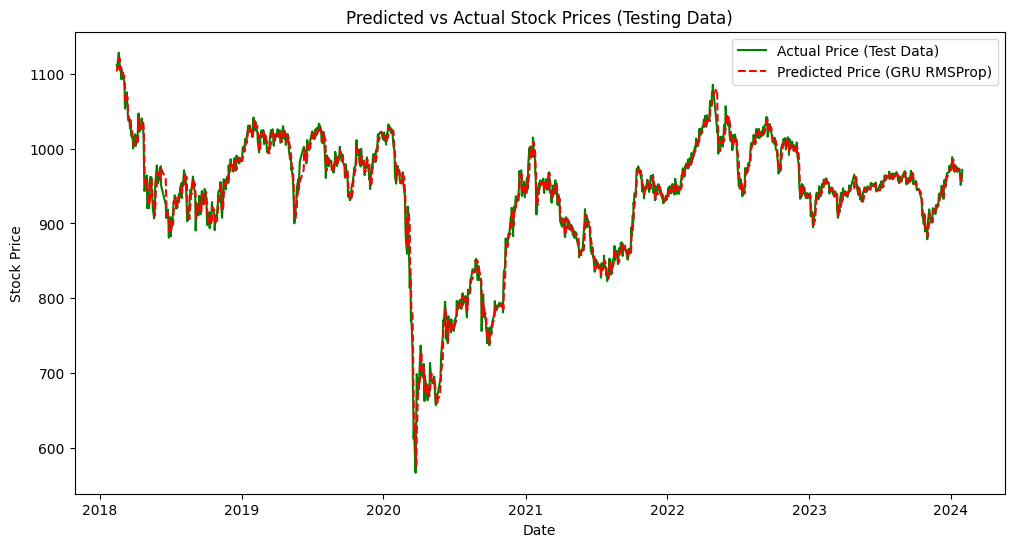

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(dates[train_size+validation_size+time_steps:], y_test, label='Actual Price (Test Data)', color='green')
plt.plot(dates[train_size+validation_size+time_steps:], predictions_gru_rmsprop, label='Predicted Price (GRU RMSProp)', linestyle='--', color='red')
plt.title('Predicted vs Actual Stock Prices (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

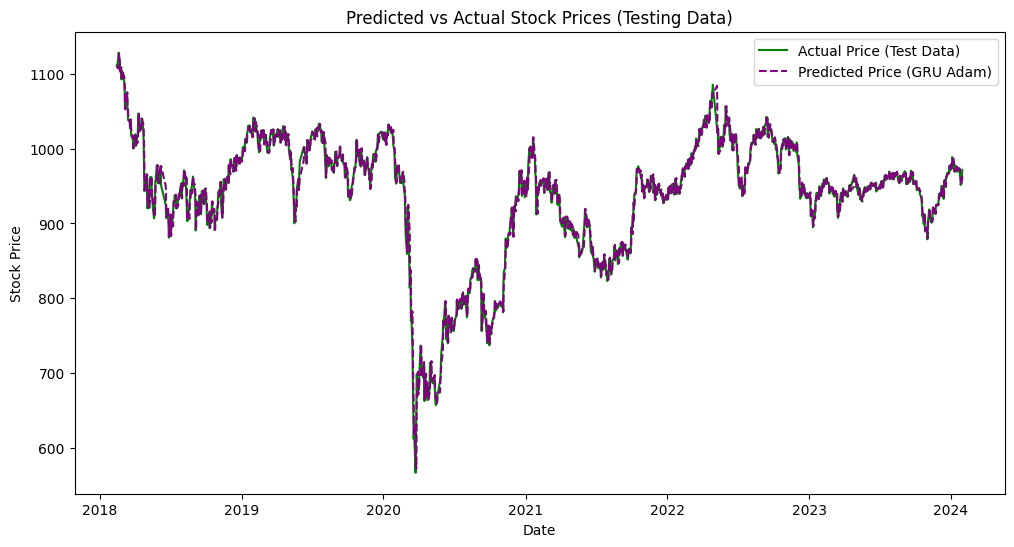

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(dates[train_size+validation_size+time_steps:], y_test, label='Actual Price (Test Data)', color='green')
plt.plot(dates[train_size+validation_size+time_steps:], predictions_gru_adam, label='Predicted Price (GRU Adam)', linestyle='--', color='purple')
plt.title('Predicted vs Actual Stock Prices (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

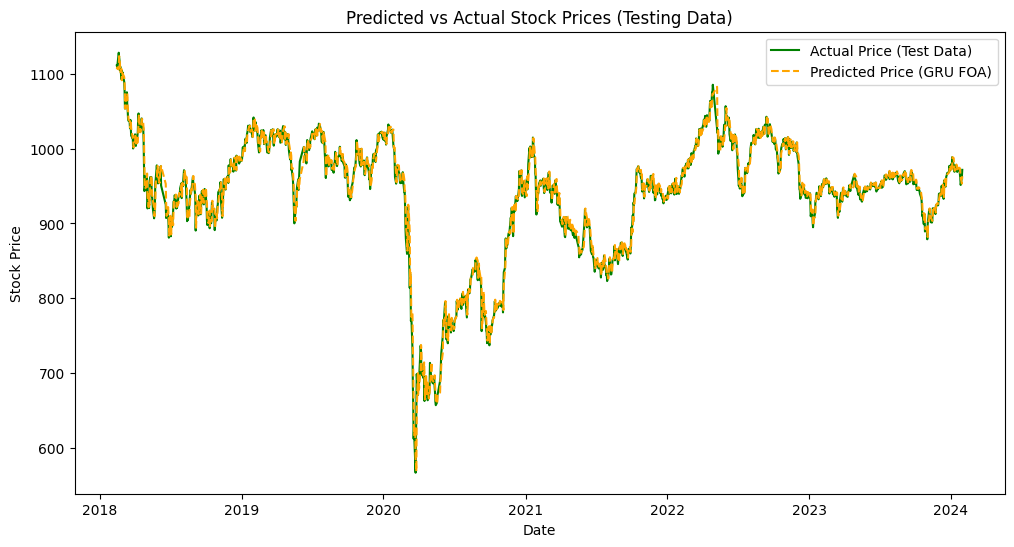

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(dates[train_size+validation_size+time_steps:], y_test, label='Actual Price (Test Data)', color='green')
plt.plot(dates[train_size+validation_size+time_steps:], predictions_gru_foa, label='Predicted Price (GRU FOA)', linestyle='--', color='orange')
plt.title('Predicted vs Actual Stock Prices (Testing Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


=== Hasil Evaluasi Hyperparameter ===
  Hyperparameter  Val Loss  Perubahan (%)
0          units  0.003702     123.273452
1  learning_rate  0.001005     -39.374071
2        dropout  0.003216      93.980749
3     activation  0.001893      14.183246
4     batch_size  0.004178     151.987321
5     num_layers  0.001170     -29.426041
6         epochs  0.004182     152.193067


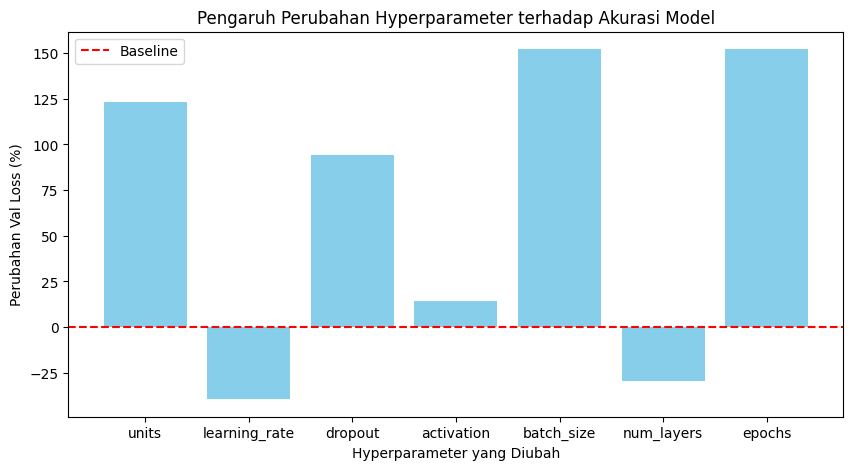

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pastikan best_params sudah didefinisikan sebelumnya dari FOA
best_units, best_lr, best_dropout, best_activation, best_batch_size, best_num_layers, best_epochs = best_params

# Default parameters
default_units = 50
default_lr = 0.001
default_dropout = 0
default_activation = 'tanh'
default_batch_size = 32
default_num_layers = 1
default_epochs = 50

# Fungsi untuk membangun dan melatih model GRU
def train_model(units, lr, dropout, activation, batch_size, num_layers, epochs):
    model = tf.keras.Sequential()

    for _ in range(num_layers):
        model.add(tf.keras.layers.GRU(units, activation=activation, return_sequences=True))
        if dropout > 0:
            model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1))  # Output layer

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=0)

    val_loss = history.history['val_loss'][-1]
    return val_loss

# Evaluasi baseline (best FOA)
baseline_loss = train_model(best_units, best_lr, best_dropout, best_activation, best_batch_size, best_num_layers, best_epochs)

# Simpan hasil uji perubahan hyperparameter
results = {}

# Ubah satu hyperparameter ke default satu per satu
results["units"] = train_model(default_units, best_lr, best_dropout, best_activation, best_batch_size, best_num_layers, best_epochs)
results["learning_rate"] = train_model(best_units, default_lr, best_dropout, best_activation, best_batch_size, best_num_layers, best_epochs)
results["dropout"] = train_model(best_units, best_lr, default_dropout, best_activation, best_batch_size, best_num_layers, best_epochs)
results["activation"] = train_model(best_units, best_lr, best_dropout, default_activation, best_batch_size, best_num_layers, best_epochs)
results["batch_size"] = train_model(best_units, best_lr, best_dropout, best_activation, default_batch_size, best_num_layers, best_epochs)
results["num_layers"] = train_model(best_units, best_lr, best_dropout, best_activation, best_batch_size, default_num_layers, best_epochs)
results["epochs"] = train_model(best_units, best_lr, best_dropout, best_activation, best_batch_size, best_num_layers, default_epochs)

# Konversi hasil ke DataFrame untuk visualisasi
df_results = pd.DataFrame({
    "Hyperparameter": results.keys(),
    "Val Loss": results.values(),
    "Perubahan (%)": [(loss - baseline_loss) / baseline_loss * 100 for loss in results.values()]
})

# Tampilkan hasil dalam tabel
print("\n=== Hasil Evaluasi Hyperparameter ===")
print(df_results)

# Visualisasi perubahan val_loss
plt.figure(figsize=(10,5))
plt.bar(df_results["Hyperparameter"], df_results["Perubahan (%)"], color="skyblue")
plt.axhline(y=0, color='r', linestyle='--', label="Baseline")
plt.xlabel("Hyperparameter yang Diubah")
plt.ylabel("Perubahan Val Loss (%)")
plt.title("Pengaruh Perubahan Hyperparameter terhadap Akurasi Model")
plt.legend()
plt.show()
